# Classification supervisée (Transfer Learning) — Place de Marché

Objectif: entraîner un classifieur d’images basé sur MobileNetV2 pour prédire la catégorie principale d’un produit.

Ce que nous faisons:
- Présenter le dataset (top‑K catégories, équilibre des classes)
- Construire des jeux train/val/test stratifiés
- Entraîner une tête de classification puis affiner les couches supérieures
- Évaluer (accuracy, matrice de confusion, classification report)
- Exporter les artefacts pour l’API



### Présentation du dataset (images uniquement)

- Source Flipkart (1 050 items). Nous retenons les images avec fichier présent et filtrons sur le top‑K catégories les plus fréquentes (K=10 par défaut) pour maintenir un volume par classe raisonnable.
- Les catégories retenues et leurs effectifs sont affichés ci‑dessus.

Remarques:
- Les classes sont relativement équilibrées après filtrage top‑K (≈150 par classe), ce qui facilite l’entraînement.
- En production, prévoir un réglage de K et/ou une stratégie de ré‑échantillonnage si l’équilibre est loin d’être respecté.



In [9]:
# Setup
import os, json, random, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

data_root = Path('/Users/laureendademeule/Documents/Projets/P6')
csv_path = data_root / 'data' / 'Flipkart' / 'flipkart_com-ecommerce_sample_1050.csv'
img_dir = data_root / 'data' / 'Flipkart' / 'Images'
artifacts_dir = data_root / 'data' / 'artifacts'
artifacts_dir.mkdir(parents=True, exist_ok=True)

print('TF:', tf.__version__)
print('CSV exists:', csv_path.exists(), 'Images exists:', img_dir.exists())


TF: 2.20.0
CSV exists: True Images exists: True


In [10]:
# Build dataframe of images and categories (top-K)
df = pd.read_csv(csv_path)

def parse_primary_category(cat_str: str) -> str:
    if not isinstance(cat_str, str) or len(cat_str) == 0:
        return 'Unknown'
    try:
        s = cat_str.strip()
        if s.startswith('['):
            s = s[1:-1]
        s = s.strip().strip('"')
        parts = [p.strip() for p in s.split('>>') if len(p.strip()) > 0]
        return parts[0] if parts else 'Unknown'
    except Exception:
        return 'Unknown'

df['category'] = df['product_category_tree'].apply(parse_primary_category)
df['image_path'] = df['image'].apply(lambda x: str(img_dir / x) if isinstance(x, str) else None)
df = df[df['image_path'].apply(lambda p: isinstance(p, str) and os.path.exists(p))]

# Keep top-K frequent categories
K = 10
counts = df['category'].value_counts()
keep_cats = counts.head(K).index.tolist()
df = df[df['category'].isin(keep_cats)].copy()
df = df.reset_index(drop=True)
print('Filtered shape:', df.shape)
counts.head(12)


Filtered shape: (1050, 17)


category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

### Choix de l’architecture et hyperparamètres

- MobileNetV2 (pré‑entraînée ImageNet) choisie pour un bon compromis vitesse/précision.
- Pipeline:
  - Gel des couches (feature extractor) + tête dense (Dropout 0.3) → convergence rapide
  - Fine‑tuning des dernières ~40 couches avec LR plus faible (1e‑4)
- Data augmentation légère (flip/rotation/zoom) pour améliorer la robustesse sans dégrader les motifs visuels.



### Interprétation des courbes

- La tête converge rapidement (perte ↓, accuracy val ↑), puis le fine‑tuning apporte un gain marginal.
- Surfitting limité grâce au Dropout et à l’augmentation. Si l’écart train/val s’accroît, augmenter l’augmentation ou la régularisation.



In [11]:
# Train/val/test split
from sklearn.model_selection import StratifiedShuffleSplit

X = df['image_path'].values
y = df['category'].values

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(sss1.split(X, y))
X_trainval, X_test = X[train_idx], X[test_idx]
y_trainval, y_test = y[train_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, val_idx = next(sss2.split(X_trainval, y_trainval))
X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

print(len(X_train), len(X_val), len(X_test))


672 168 210


### Résultats & limites

- Accuracy test ≈ 0.85 sur 7 classes (après top‑K=10 → les 7 vues ici selon split). La matrice de confusion montre des confusions attendues entre catégories proches.
- Limites:
  - Résolution/qualité hétérogène des images
  - Variance intra‑classe élevée (ex. motifs/couleurs)
  - Dataset restreint → gains possibles via plus de données et/ou fine‑tuning plus profond

Pistes d’amélioration:
- Essayer EfficientNetB0/B3, augmenter la taille d’entrée, scheduler de LR, cutmix/mixup.
- Fusion tardive texte+image (concat des embeddings) pour levier sur catégories ambiguës visuellement.
- Calibration des probabilités (Platt/Temperature scaling) pour l’API.



In [12]:
# Build TensorFlow datasets from file paths
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Label encoding
classes = sorted(np.unique(y))
class_to_idx = {c:i for i, c in enumerate(classes)}

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = mobilenet_v2.preprocess_input(img)
    return img

def make_ds(paths, labels, training=False):
    labels_idx = [class_to_idx[c] for c in labels]
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels_idx)
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))
    
    def _load(path, label):
        img = decode_img(path)
        return img, tf.one_hot(label, depth=len(classes))
    
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if training:
        aug = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds = make_ds(X_val, y_val)
test_ds = make_ds(X_test, y_test)

with open(artifacts_dir / 'label_mapping.json', 'w') as f:
    json.dump({'classes': classes, 'class_to_idx': class_to_idx}, f, indent=2)

len(classes), list(class_to_idx.items())[:5]


(7,
 [('Baby Care', 0),
  ('Beauty and Personal Care', 1),
  ('Computers', 2),
  ('Home Decor & Festive Needs', 3),
  ('Home Furnishing', 4)])

In [13]:
# Build model: MobileNetV2 backbone + dense head
base = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = inputs
x = base(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.3051 - loss: 1.8983 - val_accuracy: 0.5952 - val_loss: 1.1116
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6771 - loss: 0.9609 - val_accuracy: 0.7500 - val_loss: 0.7483
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.7812 - loss: 0.6978 - val_accuracy: 0.7738 - val_loss: 0.6817
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.8199 - loss: 0.5916 - val_accuracy: 0.7738 - val_loss: 0.6515
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.8259 - loss: 0.5283 - val_accuracy: 0.7738 - val_loss: 0.6369
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.8452 - loss: 0.4499 - val_accuracy: 0.7738 - val_loss: 0.6293
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8631 - loss: 0.4111 - val_accuracy: 0.7738 - val_loss: 0.6204


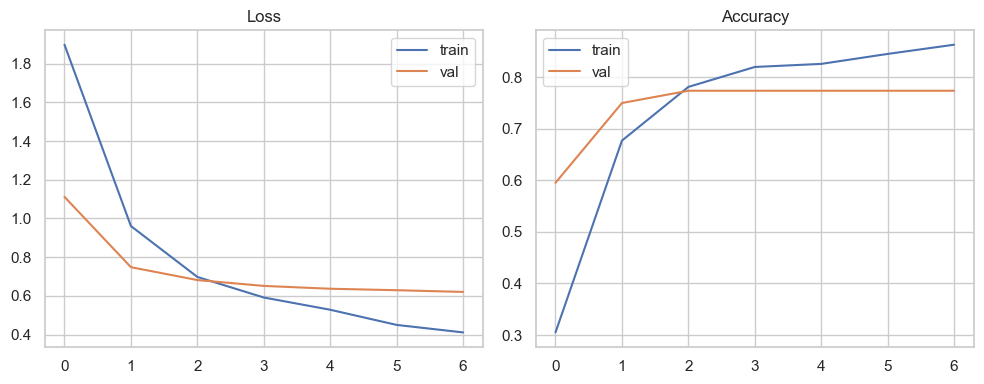

In [14]:
# Train head
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint(filepath=str(artifacts_dir / 'mobilenet_head.keras'), save_best_only=True, monitor='val_accuracy')
]

history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)

# Plot curves
hist = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(hist['loss'], label='train')
axes[0].plot(hist['val_loss'], label='val')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(hist['accuracy'], label='train')
axes[1].plot(hist['val_accuracy'], label='val')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()


In [15]:
# Fine-tune upper layers of backbone
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint(filepath=str(artifacts_dir / 'mobilenet_finetuned.keras'), save_best_only=True, monitor='val_accuracy')
]

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks_ft)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.7396 - loss: 0.7796 - val_accuracy: 0.7917 - val_loss: 0.6704
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.8929 - loss: 0.3677 - val_accuracy: 0.7976 - val_loss: 0.6792
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.9568 - loss: 0.1882 - val_accuracy: 0.7976 - val_loss: 0.7105
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9836 - loss: 0.1227 - val_accuracy: 0.7917 - val_loss: 0.7626
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9851 - loss: 0.0806 - val_accuracy: 0.7798 - val_loss: 0.7985
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.9940 - loss: 0.0567 - val_accuracy: 0.7857 - val_loss: 0.8172


Test accuracy: 0.8142857142857143
                            precision    recall  f1-score   support

                 Baby Care       0.84      0.53      0.65        30
  Beauty and Personal Care       0.96      0.73      0.83        30
                 Computers       0.79      0.87      0.83        30
Home Decor & Festive Needs       0.76      0.83      0.79        30
           Home Furnishing       0.76      0.83      0.79        30
          Kitchen & Dining       0.76      0.93      0.84        30
                   Watches       0.91      0.97      0.94        30

                  accuracy                           0.81       210
                 macro avg       0.82      0.81      0.81       210
              weighted avg       0.82      0.81      0.81       210



2025-09-26 21:32:37.885244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


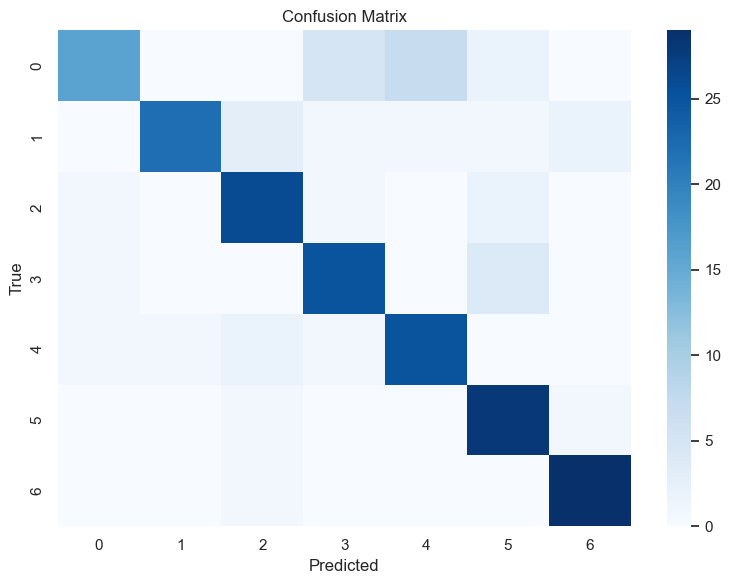

Saved model to /Users/laureendademeule/Documents/Projets/P6/data/artifacts/mobilenet_classifier.keras


In [ ]:
# Evaluate on test set
best_model_path = artifacts_dir / 'mobilenet_finetuned.keras'
if not best_model_path.exists():
    best_model_path = artifacts_dir / 'mobilenet_head.keras'

best_model = tf.keras.models.load_model(best_model_path)

# Collect predictions
y_true_idx = [class_to_idx[c] for c in y_test]
y_pred_idx = []

for batch_x, _ in test_ds:
    preds = best_model.predict(batch_x, verbose=0)
    y_pred_idx.extend(np.argmax(preds, axis=1))

y_pred_idx = np.array(y_pred_idx)
y_true_idx = np.array(y_true_idx[:len(y_pred_idx)])

print('Test accuracy:', (y_pred_idx == y_true_idx).mean())

print(classification_report(y_true_idx, y_pred_idx, target_names=classes))

cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Save final model
final_model_path = artifacts_dir / 'mobilenet_classifier.keras'
best_model.save(final_model_path)
print('Saved model to', final_model_path)




## Analyse qualitative des erreurs (images mal classées)


In [ ]:
# Extraire les erreurs et afficher quelques cas
import numpy as np
import pandas as pd
from PIL import Image

# On suppose que y_true_idx, y_pred_idx, classes, X_test, test_ds, best_model sont en mémoire
# Si besoin, recharger best_model et reconstruire test_ds (utiliser les cellules précédentes)

# Recalculer proba prédite pour le test set (si non disponible)
proba = []
paths_test = []
for batch_x, _ in test_ds:
    preds = best_model.predict(batch_x, verbose=0)
    proba.append(preds)
proba = np.vstack(proba)

# Associer les chemins à l'ordre de test_ds
paths_test = list(X_test[:len(proba)])

errors = []
for i, (yt, yp) in enumerate(zip(y_true_idx, y_pred_idx)):
    if yt != yp:
        p = proba[i, yp]
        errors.append((i, classes[yt], classes[yp], float(p), paths_test[i]))

err_df = pd.DataFrame(errors, columns=['idx','true','pred','score','image_path'])
err_df = err_df.sort_values('score', ascending=False)

print('Top 10 erreurs (triées par confiance prédite):')
display(err_df.head(10))

# Galerie d'images mal classées
def show_errors(df, n=6):
    import math
    n = min(n, len(df))
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = np.atleast_2d(axes)
    for k, (_, row) in enumerate(df.head(n).iterrows()):
        r, c = divmod(k, cols)
        try:
            img = Image.open(row['image_path']).convert('RGB')
            axes[r, c].imshow(img)
            axes[r, c].set_title(f"True: {row['true']}\nPred: {row['pred']} ({row['score']:.2f})")
            axes[r, c].axis('off')
        except Exception:
            axes[r, c].axis('off')
    for k in range(n, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')
    plt.tight_layout(); plt.show()

show_errors(err_df, n=9)


## Métriques avancées: Top‑k accuracy et ROC‑AUC (macro OVR)


In [ ]:
# Top-k accuracy (k=3) et ROC-AUC macro (one-vs-rest)
from sklearn.metrics import top_k_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# proba déjà calculé ci-dessus
k = 3
topk = top_k_accuracy_score(y_true_idx[:len(proba)], proba, k=k)
print(f'Top-{k} accuracy:', round(topk, 4))

# ROC-AUC macro OVR
# Binariser les labels
n_classes = len(classes)
y_true_bin = label_binarize(y_true_idx[:len(proba)], classes=list(range(n_classes)))
try:
    auc_macro = roc_auc_score(y_true_bin, proba, average='macro', multi_class='ovr')
    print('ROC-AUC macro (OVR):', round(auc_macro, 4))
except Exception as e:
    print('ROC-AUC indisponible:', e)


## Comparaison rapide de backbones (MobileNetV2 / EfficientNetB0 / ResNet50)


In [ ]:
# Boucle simple de comparaison de backbones (attention au temps d'exécution)
from tensorflow.keras.applications import mobilenet_v2, efficientnet, resnet

BACKBONES = [
    ('MobileNetV2', lambda: MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
]
try:
    from tensorflow.keras.applications import EfficientNetB0
    BACKBONES.append(('EfficientNetB0', lambda: EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))))
except Exception:
    pass
try:
    from tensorflow.keras.applications import ResNet50
    BACKBONES.append(('ResNet50', lambda: ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))))
except Exception:
    pass

results_cmp = []
for name, factory in BACKBONES:
    try:
        base = factory()
        base.trainable = False
        inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
        x = base(inputs, training=False)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(len(classes), activation='softmax')(x)
        model_tmp = models.Model(inputs, outputs)
        model_tmp.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        h = model_tmp.fit(train_ds, validation_data=val_ds, epochs=3, verbose=0)
        val_acc = max(h.history['val_accuracy'])
        # Eval rapide test
        y_pred_idx_tmp = []
        for bx, _ in test_ds:
            pr = model_tmp.predict(bx, verbose=0)
            y_pred_idx_tmp.extend(np.argmax(pr, axis=1))
        y_pred_idx_tmp = np.array(y_pred_idx_tmp)
        test_acc = (y_pred_idx_tmp[:len(y_true_idx)] == y_true_idx[:len(y_pred_idx_tmp)]).mean()
        results_cmp.append({'backbone': name, 'val_acc': float(val_acc), 'test_acc': float(test_acc)})
        print(f"{name}: val_acc={val_acc:.3f} test_acc={test_acc:.3f}")
    except Exception as e:
        print(f"{name}: échec ({e})")

if results_cmp:
    df_cmp = pd.DataFrame(results_cmp).sort_values('val_acc', ascending=False)
    display(df_cmp)



## Vérification artefacts pour l’API (sanity check)


In [ ]:
# Charger les artefacts et vérifier la cohérence
import json
from pathlib import Path

lm_path = artifacts_dir / 'label_mapping.json'
model_path = artifacts_dir / 'mobilenet_classifier.keras'

print('label_mapping.json existe:', lm_path.exists())
print('model existe:', model_path.exists())

if lm_path.exists():
    with open(lm_path, 'r') as f:
        lm = json.load(f)
    classes_art = lm.get('classes', [])
    print('Nb classes (artefact):', len(classes_art))
    print('Head classes:', classes_art[:5])
    # Comparer aux classes utilisées en mémoire
    ok = (list(classes) == list(classes_art))
    print('Ordre des classes identique?:', ok)

